학번: 20150962
이름: 채현종

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
from datetime import datetime, date
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import minmax_scale
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM

In [2]:
sns.set_style('whitegrid')
np.random.seed(42)

## 1. 주가데이터 불러오기. 5점
kodex200 주가
s069500.csv

In [3]:
kodex200 = pd.read_csv('C:/Users/yssg9187/Desktop/20-2/3. 응용자료분석/D_data/s069500.csv')
kodex200.head()

,Date,Open,High,Low,Close,Volume,Change
0,2010-01-04,18973,19119,18973,19100,883268,0.006057
1,2010-01-05,19155,19163,19028,19081,1781284,-0.000995
2,2010-01-06,19110,19243,19103,19214,962659,0.006970
3,2010-01-07,19203,19224,18965,18976,1250996,-0.012387
4,2010-01-08,19052,19060,18810,19048,1428088,0.003794


## 2. Close를 price로, Date를 day로 이름을 바꿉니다.5점

In [4]:
kodex200 = kodex200.rename(columns={'Close':'price', 'Date':'day'})
kodex200.columns

Index(['day', 'Open', 'High', 'Low', 'price', 'Volume', 'Change'], dtype='object')

## 3. Open, High, Low, Volumn, Change를 지웁니다. 5점

In [5]:
kodex200 = kodex200.drop(['Open', 'High', 'Low', 'Volume', 'Change'], axis=1)
kodex200.columns

Index(['day', 'price'], dtype='object')

## 4. day를 index로 지정합니다. 5점

In [6]:
kodex200 = kodex200.set_index('day')

## 5. 최소값0, 최대값 1로 스케일을 조정합니다. 10점

In [7]:
kodex200_scaled = kodex200.apply(minmax_scale)

## 6. 63일간의 거래데이터를 이용하여 그 다음날 주가를 예측하고자 합니다. 이에 필요한 x data와 y data를 구성합니다. 10점

In [8]:
def create_univariate_rnn_data(data, window_size):
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    n = data.shape[0]
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [9]:
window_size = 63

In [10]:
X, y = create_univariate_rnn_data(kodex200_scaled, window_size=window_size)

In [11]:
X

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
day,,,,,,,,,,,,,,,,,,,,,
2010-04-05,0.110301,0.109018,0.117996,0.101931,0.106791,0.106791,0.108208,0.087350,0.102201,0.108208,...,0.081139,0.093898,0.093898,0.095518,0.102538,0.099433,0.107736,0.102876,0.123329,0.128865
2010-04-06,0.109018,0.117996,0.101931,0.106791,0.106791,0.108208,0.087350,0.102201,0.108208,0.114689,...,0.093898,0.093898,0.095518,0.102538,0.099433,0.107736,0.102876,0.123329,0.128865,0.135952
2010-04-07,0.117996,0.101931,0.106791,0.106791,0.108208,0.087350,0.102201,0.108208,0.114689,0.115836,...,0.093898,0.095518,0.102538,0.099433,0.107736,0.102876,0.123329,0.128865,0.135952,0.136493
2010-04-08,0.101931,0.106791,0.106791,0.108208,0.087350,0.102201,0.108208,0.114689,0.115836,0.117321,...,0.095518,0.102538,0.099433,0.107736,0.102876,0.123329,0.128865,0.135952,0.136493,0.134197
2010-04-09,0.106791,0.106791,0.108208,0.087350,0.102201,0.108208,0.114689,0.115836,0.117321,0.128460,...,0.102538,0.099433,0.107736,0.102876,0.123329,0.128865,0.135952,0.136493,0.134197,0.137235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-20,0.775348,0.790198,0.785473,0.814095,0.806669,0.794924,0.784123,0.802957,0.844404,0.854867,...,0.942284,0.947010,0.967598,0.968273,0.977049,0.978736,0.957473,0.941609,0.929121,0.933846
2020-10-21,0.790198,0.785473,0.814095,0.806669,0.794924,0.784123,0.802957,0.844404,0.854867,0.857567,...,0.947010,0.967598,0.968273,0.977049,0.978736,0.957473,0.941609,0.929121,0.933846,0.948697
2020-10-22,0.785473,0.814095,0.806669,0.794924,0.784123,0.802957,0.844404,0.854867,0.857567,0.841366,...,0.967598,0.968273,0.977049,0.978736,0.957473,0.941609,0.929121,0.933846,0.948697,0.955448


In [12]:
y

,price
day,
2010-04-05,0.135952
2010-04-06,0.136493
2010-04-07,0.134197
2010-04-08,0.137235
2010-04-09,0.131362
...,...
2020-10-20,0.948697
2020-10-21,0.955448
2020-10-22,0.940934


## 7. 2019년까지의 데이터는 train data, 2020년 데이터는 test data로 구분합니다. 10점

In [13]:
X_train = X[:'2020'].values.reshape(-1, window_size, 1)
y_train = y[:'2020']

In [14]:
X_train.shape

(2403, 63, 1)

In [15]:
X_train

array([[[0.11030107],
        [0.1090185 ],
        [0.11799649],
        ...,
        [0.10287566],
        [0.12332928],
        [0.12886459]],

       [[0.1090185 ],
        [0.11799649],
        [0.10193061],
        ...,
        [0.12332928],
        [0.12886459],
        [0.13595248]],

       [[0.11799649],
        [0.10193061],
        [0.10679087],
        ...,
        [0.12886459],
        [0.13595248],
        [0.13649251]],

       ...,

       [[0.63196976],
        [0.63527744],
        [0.61610639],
        ...,
        [0.77480761],
        [0.7744701 ],
        [0.76198191]],

       [[0.63527744],
        [0.61610639],
        [0.63129472],
        ...,
        [0.7744701 ],
        [0.76198191],
        [0.76987984]],

       [[0.61610639],
        [0.63129472],
        [0.63561496],
        ...,
        [0.76198191],
        [0.76987984],
        [0.79836641]]])

In [16]:
n_obs, window_size, n_features = X_train.shape

In [17]:
y_train.shape

(2403, 1)

In [18]:
X_test = X['2020':].values.reshape(-1, window_size, 1)
y_test = y['2020':]

In [19]:
X_test.shape

(202, 63, 1)

In [20]:
y_test.shape

(202, 1)

## 8. Keras LSTM Layer를 이용기 위하여 hidden units을 30으로 합니다. 10점

In [21]:
hidden_units=30

rnn = Sequential([
    LSTM(units=hidden_units, 
         input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

In [22]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 30)                3840      
_________________________________________________________________
Output (Dense)               (None, 1)                 31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


## 9. epochs는 50번, batch size는 30으로 지정하여 모델을 training 합니다. 10점

In [23]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

rnn.compile(loss='mean_squared_error', optimizer=optimizer)

result = rnn.fit(X_train,
                 y_train,
                 epochs=50,
                 batch_size=30,
                 validation_data=(X_test, y_test),
                 verbose=1)

Epoch 1/50
81/81 [==============================] - 3s 33ms/step - loss: 0.0043 - val_loss: 0.0053
Epoch 2/50
81/81 [==============================] - 2s 25ms/step - loss: 0.0012 - val_loss: 0.0053
Epoch 3/50
81/81 [==============================] - 2s 26ms/step - loss: 9.5526e-04 - val_loss: 0.0037
Epoch 4/50
81/81 [==============================] - 2s 26ms/step - loss: 8.2163e-04 - val_loss: 0.0061
Epoch 5/50
81/81 [==============================] - 2s 29ms/step - loss: 7.1090e-04 - val_loss: 0.0029
Epoch 6/50
81/81 [==============================] - 2s 24ms/step - loss: 6.3619e-04 - val_loss: 0.0024
Epoch 7/50
81/81 [==============================] - 3s 33ms/step - loss: 5.7341e-04 - val_loss: 0.0022
Epoch 8/50
81/81 [==============================] - 2s 29ms/step - loss: 5.2800e-04 - val_loss: 0.0039
Epoch 9/50
81/81 [==============================] - 2s 27ms/step - loss: 4.8854e-04 - val_loss: 0.0022
Epoch 10/50
81/81 [==============================] - 2s 28ms/step - loss: 4.4348e

## 10. test predict값과, train predict값을 저장하여 한 데이터로 통합니다. 20점

In [24]:
def eval_result():
    test_predict = pd.Series(rnn.predict(X_test).squeeze(), index=y_test.index)
    train_predict = pd.Series(rnn.predict(X_train).squeeze(), index=y_train.index)
    rmse = np.sqrt(mean_squared_error(test_predict, y_test))
    return test_predict, train_predict, rmse

In [25]:
test_predict, train_predict, rmse = eval_result()

In [26]:
# test predict와 train predict를 prediction으로 바인딩?
predictions = (test_predict.to_frame('prediction').assign(data='test')
               .append(train_predict.to_frame('prediction').assign(data='train')))
predictions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2605 entries, 2020-01-02 to 2019-12-30
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  2605 non-null   float32
 1   data        2605 non-null   object 
dtypes: float32(1), object(1)
memory usage: 50.9+ KB


In [27]:
results = kodex200_scaled.join(predictions).dropna()
results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2605 entries, 2010-04-05 to 2020-10-26
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price       2605 non-null   float64
 1   prediction  2605 non-null   float32
 2   data        2605 non-null   object 
dtypes: float32(1), float64(1), object(1)
memory usage: 71.2+ KB


In [29]:
kodex200_scaled['Train Prediction'] = pd.Series(train_predict.squeeze(), index=y_train.index)
kodex200_scaled['Test Prediction'] = pd.Series(test_predict.squeeze(), index=y_test.index)

In [30]:
training_error = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
testing_error = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print('Training Error: {:.4f} | Test Error: {:.4f}'.format(training_error, testing_error))

Training Error: 0.0168 | Test Error: 0.0337


## 11. 2020년 이후 예측값과 실제값을 그래프로 표현하고 RNN을이용한 예측에 대한 본인의 의견을 기술합니다. 10점

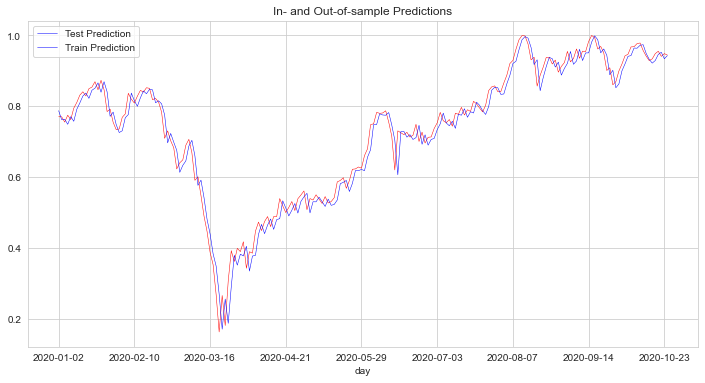

In [31]:
fig, ax = plt.subplots(figsize=(12,6))

kodex200_scaled.loc['2020':, 'price'].plot(lw=0.5, ax=ax, c='red')
kodex200_scaled.loc['2020':, ['Test Prediction', 'Train Prediction']].plot(lw=0.5, ax=ax, c = 'blue')
ax.set_title('In- and Out-of-sample Predictions')
plt.show()

실제 주가 데이터인 빨간색 그래프보다 예측 그래프, 파란색 그래프는 후행적이다.
또한 예측 그래프는 경기 순행적이고 정확도가 상당히 높다.
예측이 실제 데이터보다 후행적인 것을 이용한다면 주식 투자에서 높은 수익을 예상할 수 있다.